In [333]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

#precision, recall
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#default fig size
plt.rcParams['figure.figsize'] = [10, 5]

#stats
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from scipy.stats import f_oneway,kruskal

#unsupervised learning
from sklearn.cluster import KMeans
kmeans = KMeans()
from PlottingFunctions import plot_inertia, plot_silhouette

#for counting unique values in list
from collections import Counter



# Data Cleaning and preparation

In [334]:
#load data

data = pd.read_csv("data/data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [335]:
#check for NA
data_isna = data.isna().sum()/len(data)*100
data_isna[data_isna>0].sort_values(ascending=False)

292    91.193363
157    91.193363
158    91.193363
293    91.193363
220    85.577537
         ...    
182     0.063816
181     0.063816
180     0.063816
179     0.063816
589     0.063816
Length: 538, dtype: float64

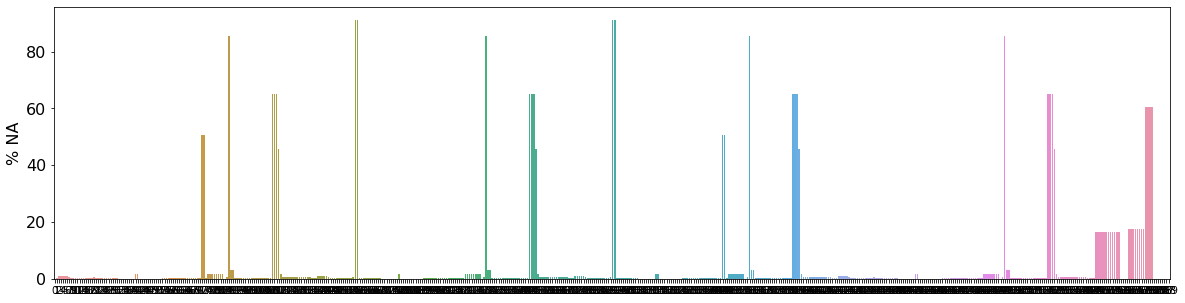

In [336]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.ylabel('% NA', fontsize=16)
plt.yticks(fontsize=16)
na_gt_zero = data_isna[data_isna>0]
sns.barplot(x=na_gt_zero.index,y=na_gt_zero)

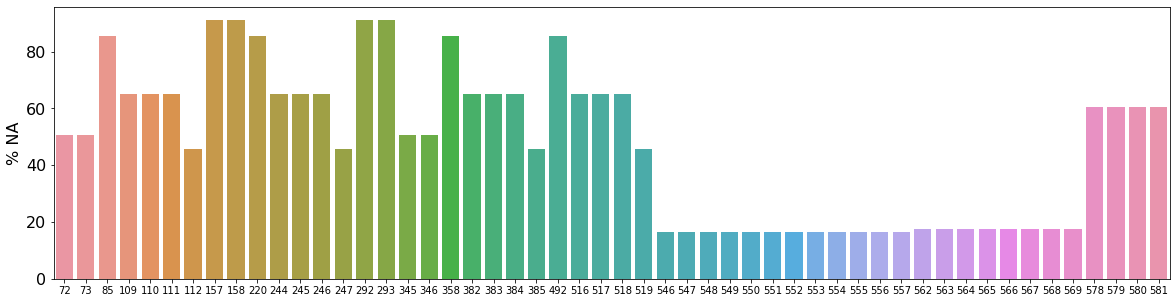

In [337]:
#replot with limit = 15%
#15% of 1567 is 235 rows
plt.rcParams['figure.figsize'] = [20, 5]
plt.ylabel('% NA', fontsize=16)
plt.yticks(fontsize=16)
na_gt_limit = data_isna[data_isna>15]
sns.barplot(x=na_gt_limit.index,y=na_gt_limit)

In [338]:
len(na_gt_limit.index)
na_gt_limit.index

Index(['72', '73', '85', '109', '110', '111', '112', '157', '158', '220',
       '244', '245', '246', '247', '292', '293', '345', '346', '358', '382',
       '383', '384', '385', '492', '516', '517', '518', '519', '546', '547',
       '548', '549', '550', '551', '552', '553', '554', '555', '556', '557',
       '562', '563', '564', '565', '566', '567', '568', '569', '578', '579',
       '580', '581'],
      dtype='object')

In [339]:
data.drop(na_gt_limit.index, inplace=True, axis=1)
print("done")

done


In [340]:
#Some features don't vary. Drop them.
features = data.drop(['Time','Pass/Fail'],axis=1)
features_range = features.max()-features.min()
no_var_features = features_range[features_range==0]
data.drop(no_var_features.index, inplace=True, axis=1)
data.columns #424 Columns remain

Index(['Time', '0', '1', '2', '3', '4', '6', '7', '8', '9',
       ...
       '577', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=424)

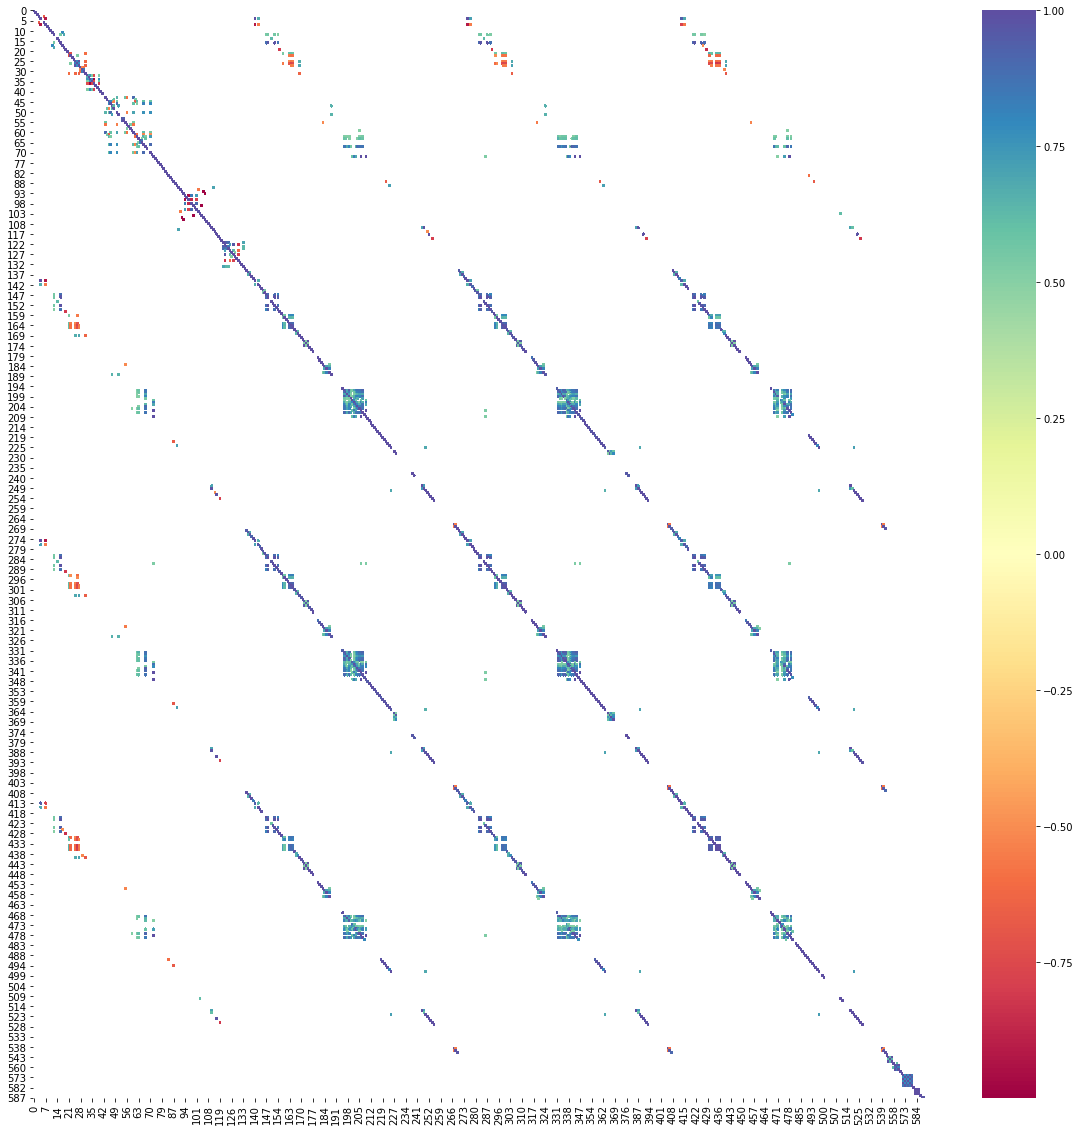

In [341]:
corrs = features.corr()
plt.rcParams['figure.figsize'] = [20, 20]
sns.heatmap(corrs[abs(corrs)>0.5], cmap="Spectral")

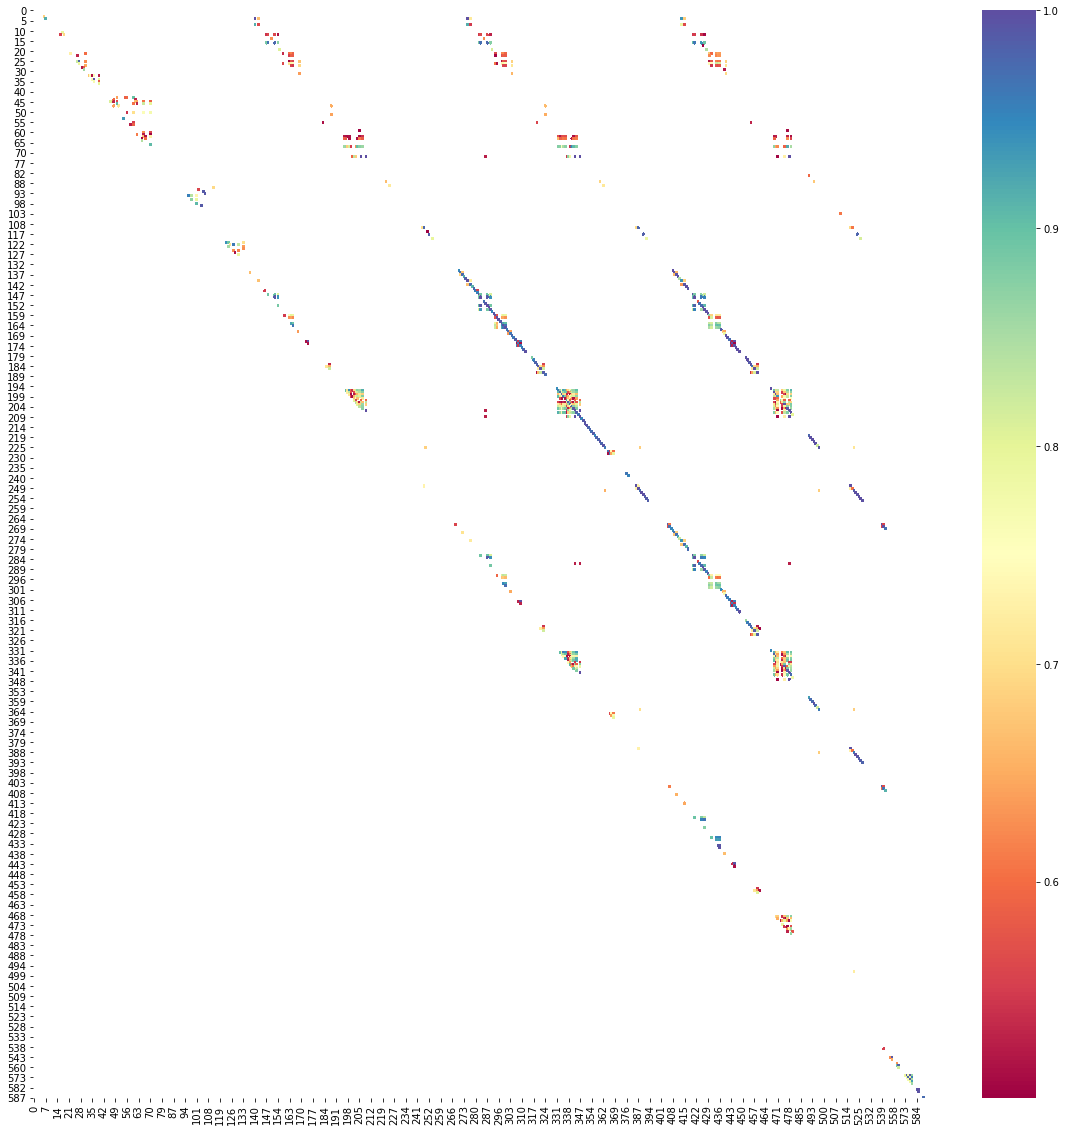

In [342]:
corrs_abs = corrs.abs()
upper_tri = corrs_abs.where(np.triu(np.ones(corrs_abs.shape),k=1).astype(np.bool))
upper_tri

sns.heatmap(upper_tri[abs(upper_tri)>0.5], cmap="Spectral")

In [343]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
len(to_drop)

212

In [344]:
data.drop(to_drop, inplace=True, axis=1)
data.columns #212 columns remain

Index(['Time', '0', '1', '2', '3', '4', '6', '8', '9', '10',
       ...
       '570', '571', '572', '573', '582', '583', '586', '587', '589',
       'Pass/Fail'],
      dtype='object', length=212)

In [345]:
#Train-test split
data_x = data.drop(['Time','Pass/Fail'], axis=1)
data_y=data['Pass/Fail']
na_filler = data_x.mean()
X_train, X_test, y_train, y_test = train_test_split(data_x.fillna(na_filler), data_y, test_size=0.2, random_state = 42)

In the test case, yield is 290/314 = 92%. Failure is 24/314 = 8%

# Random Forest

In [61]:
#Random Forest modelling
#tree_model = RandomForestClassifier(oob_score = True, n_estimators=100, class_weight='balanced_subsample')
tree_model = BalancedRandomForestClassifier(n_estimators=100)
tree_model.get_params()



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'replacement': False,
 'sampling_strategy': 'auto',
 'verbose': 0,
 'warm_start': False}

In [62]:
tree_model.fit(X_train,y_train)
predictions = tree_model.predict(X_test)
print("train score:",tree_model.score(X_train, y_train))
#print("train oob score:",tree_model.oob_score_)
print("test score:", tree_model.score(X_test,y_test))
print("Number of columns: ",len(X_train.columns))
print("test precision for fail: ",precision_score(y_test,predictions, pos_label=1)) #1 is fail
print("test recall for fail: ",recall_score(y_test,predictions, pos_label=1))
print("test precision for pass: ",precision_score(y_test,predictions, pos_label=-1)) #-1 is pass
print("test recall for pass: ",recall_score(y_test,predictions, pos_label=-1))
print(Counter(predictions))



train score: 0.7717478052673583
test score: 0.6815286624203821
Number of columns:  210
test precision for fail:  0.12
test recall for fail:  0.5
test precision for pass:  0.9439252336448598
test recall for pass:  0.696551724137931
Counter({-1: 214, 1: 100})


The Imbalanced random forest accuracies and predictions look much more realistic. Precision is low. Meaning of all the fails called, only a small amount are truly fails. Recall is kinda ok. Meaning, of all the true fails, enough were called fails.

In [56]:
#Try to improve the score with grid search
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

tree_params = [{
    
    "n_estimators":range(100,1000)
}]
grid_search_tree = GridSearchCV(tree_model, tree_params, cv=5, n_jobs=-1)
%time grid_search_tree.fit(X_train, y_train)

print("best params:",grid_search_tree.best_params_)
print("best score:",grid_search_tree.best_score_)

CPU times: user 21.1 s, sys: 1.25 s, total: 22.4 s
Wall time: 34min 20s
best params: {'n_estimators': 336}
best score: 0.747015139442231


best params: {'n_estimators': 336}
best score: 0.747015139442231


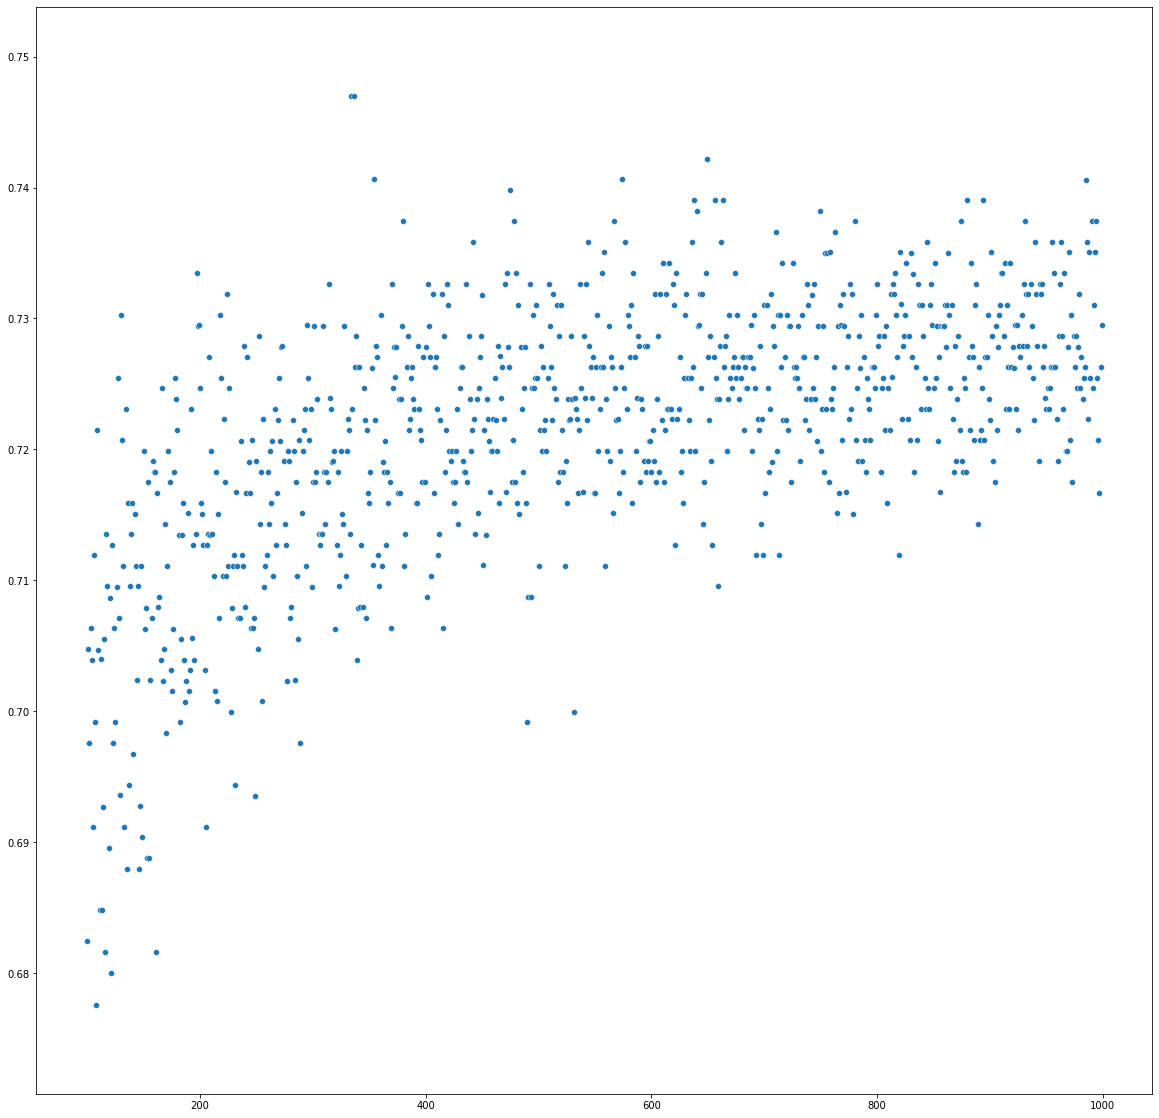

In [57]:
n_estimators = [x['n_estimators'] for x in grid_search_tree.cv_results_['params']]
scores = grid_search_tree.cv_results_['mean_test_score']
sns.scatterplot(x=n_estimators,y=scores)
print("best params:",grid_search_tree.best_params_)
print("best score:",grid_search_tree.best_score_)

#best n_trees: 336 but this looks like an outlier. In general more trees is better.


In [346]:
#optimized model
tree_model_opt = BalancedRandomForestClassifier(n_estimators=1000)
tree_model_opt.fit(X_train,y_train)
predictions = tree_model_opt.predict(X_test)
print("train score:",tree_model_opt.score(X_train, y_train))
print("test score:", tree_model_opt.score(X_test,y_test))
print("Number of columns: ",len(X_train.columns))
print("test precision for fail: ",precision_score(y_test,predictions, pos_label=1)) #1 is fail
print("test recall for fail: ",recall_score(y_test,predictions, pos_label=1))
print("test precision for pass: ",precision_score(y_test,predictions, pos_label=-1)) #-1 is pass
print("test recall for pass: ",recall_score(y_test,predictions, pos_label=-1))
print(Counter(predictions))



train score: 0.7932960893854749
test score: 0.732484076433121
Number of columns:  210
test precision for fail:  0.16666666666666666
test recall for fail:  0.625
test precision for pass:  0.9598214285714286
test recall for pass:  0.7413793103448276
Counter({-1: 224, 1: 90})


In [ ]:
# for n = 100 trees
# train score: 0.7717478052673583
# test score: 0.6815286624203821
# Number of columns:  210
# test precision for fail:  0.12
# test recall for fail:  0.5
# test precision for pass:  0.9439252336448598
# test recall for pass:  0.696551724137931
# Counter({-1: 214, 1: 100})

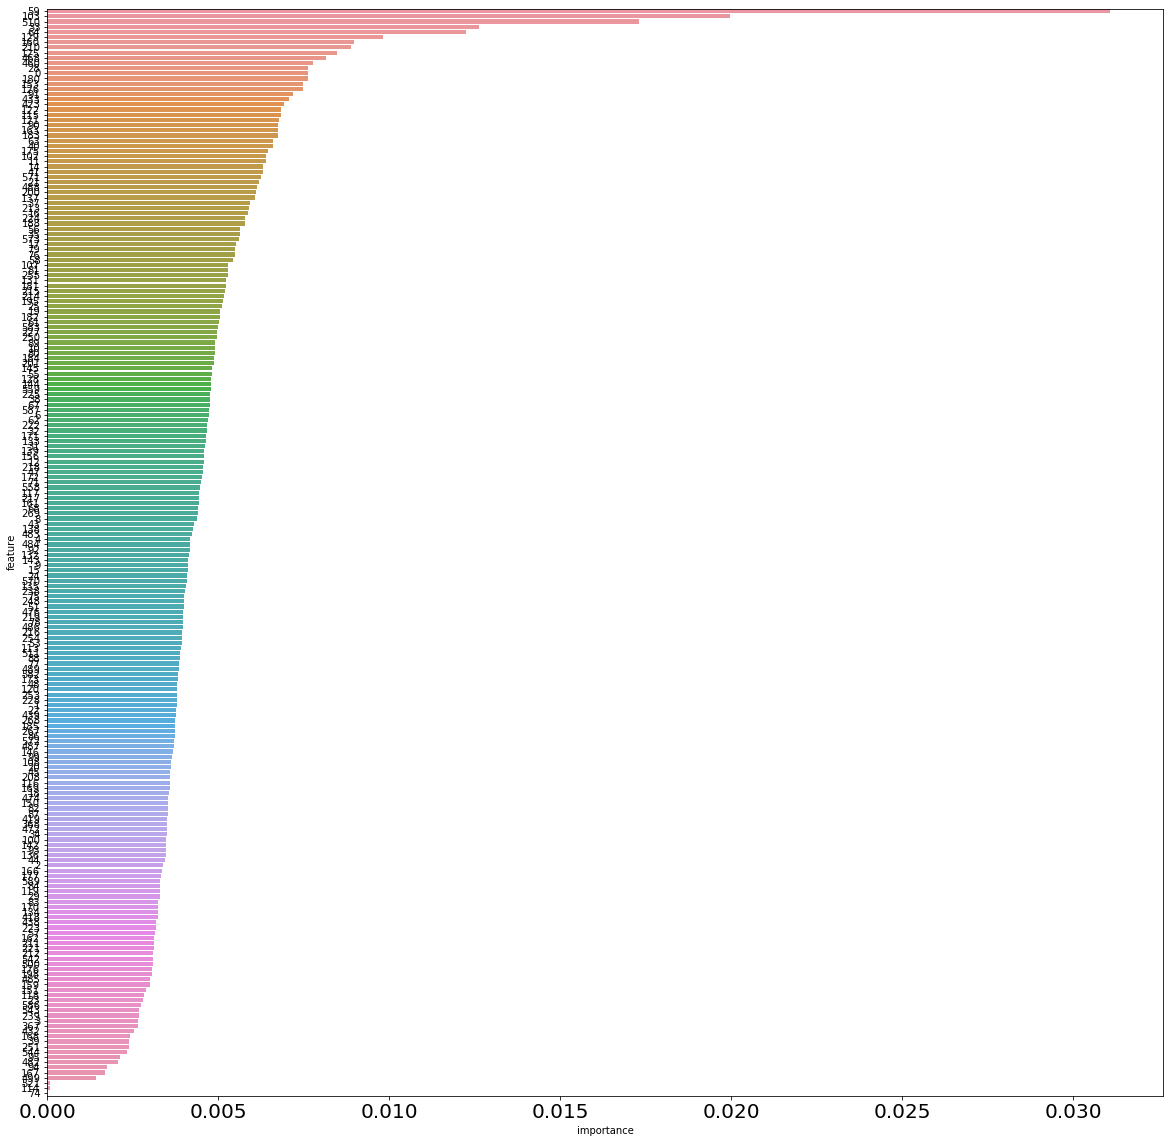

In [347]:
tree_model_params = pd.DataFrame({'feature':X_train.columns,'importance':tree_model_opt.feature_importances_}).sort_values(by='importance',ascending=False)
tree_model_params.to_csv("tree_model_params.csv")
plt.rcParams['figure.figsize'] = [20, 20]
plt.xticks(fontsize=20)
sns.barplot(x=tree_model_params['importance'],y=tree_model_params['feature'])


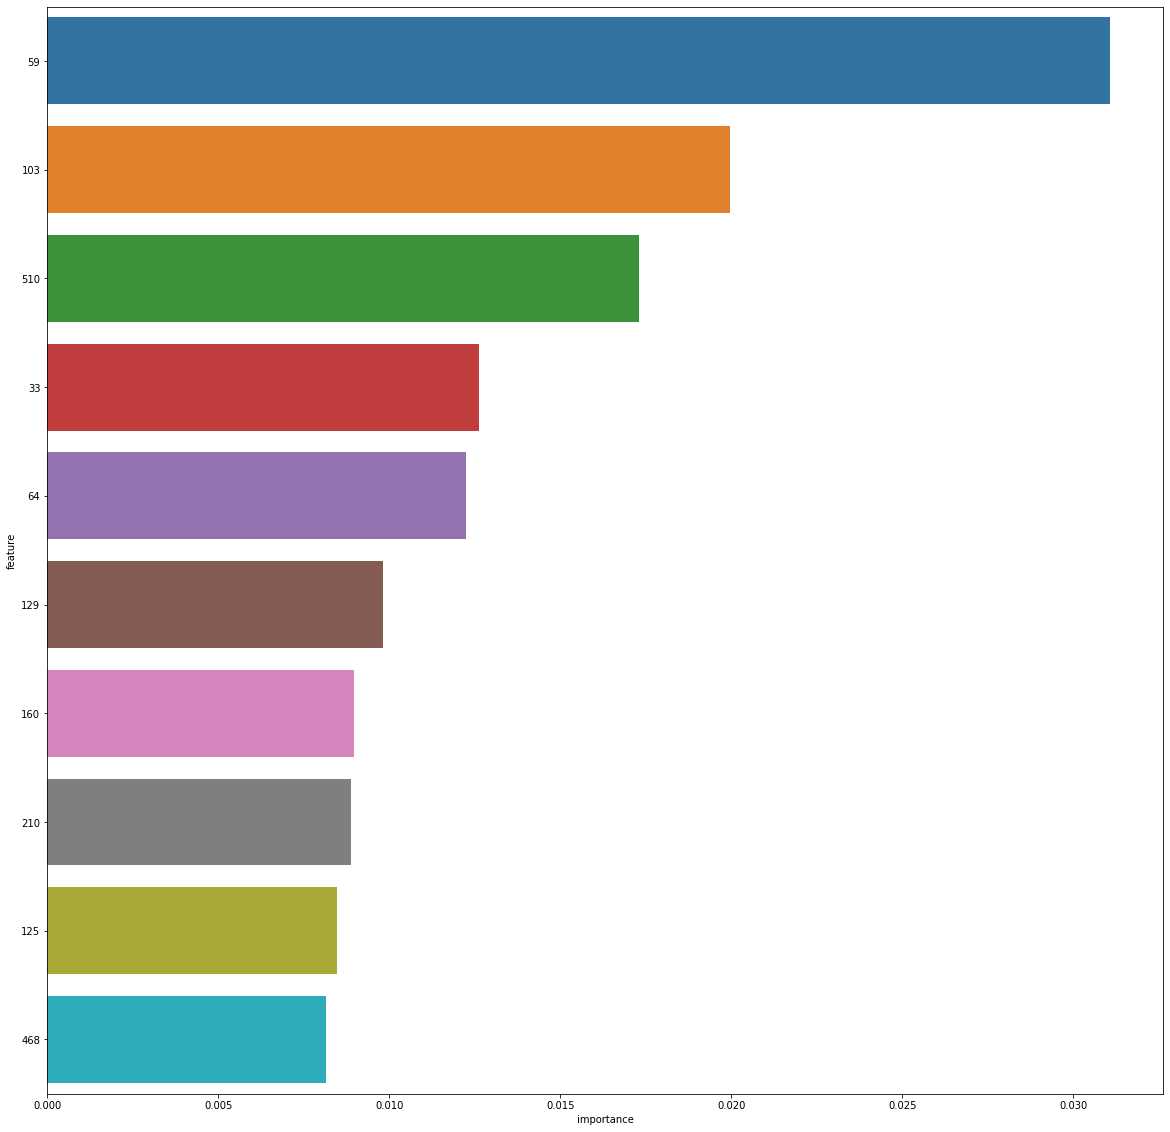

In [348]:
filter=10
sns.barplot(x=tree_model_params['importance'][:filter],y=tree_model_params['feature'][:filter])

In [309]:
#visualize tree
estimator = tree_model_opt.estimators_[5]

predictor_names = y_train
column_names = [str(x) for x in X_train.columns ]
predictor_names = [str(y) for y in y_train.unique()]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = column_names,
                class_names = predictor_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


How does this impact decisions of different modules?
If parameter is controllable, choose the one which will lead to higher chance of success. Can this be done lot by lot? Or does the tool average need to be recentered?

How to quantify highest chance of success? At each branch, we can calculate the probabilities using <strong>the cumulative distribution function</strong>.

Can also make decision based on what is simplest (i.e. les branches).




# Following a single tree to make decisions at a module

This section is based on an older model that is no longer used. However, they are still here to illustrate the point of how a tree can be used to make decisions in a factory.

In [32]:
#Test rules is manually made by looking at the tree picture and typing the limit.
test_rules = pd.read_csv("data/test_rules.csv")

In [33]:
test_rules

Feature Rule         limit
0        64   LT  2.516000e+01
1       283   LT  2.050000e+00
2       280   LT  1.000000e-02
3       307   LT  8.000000e-02
4       561   LT  3.333000e+01
5       472   LT  1.676600e+02
6       454   LT  5.150000e+00
7       457   LT  8.280000e+00
8       339   LT  1.032000e+01
9       304   LT  3.000000e-02
10      494   LT  2.900000e-01
11      494   LT  3.000000e-01
12      437   LT  4.080000e+00
13      434   LT  5.000000e+13
14      489   LT  5.924700e+02
15      102   LT -9.000000e-02
16      493   LT  2.240000e+00
17       38   LT  8.688000e+01

For each of the rules, find the probability that it is less than the limit. Note that all rules are "less than". Also need to filter out N/A values. Also need to filter out data points that are outside N sigma.


In [34]:
def clean_data(data):
    data.dropna(inplace=True) #drop 
    sigma = data.std()
    mean = data.mean()
    N_sig = 2
    LL = mean - N_sig*sigma
    UL = mean + N_sig*sigma
    
    return data[(LL < data) & (data < UL)]
    

def get_cdf(data,limit):
    
    return norm.cdf(limit, loc=data.mean(), scale=data.std())


In [35]:
# #Take an example feature and check the cummulative probability up to the limit
sample_f = '283'
test_data = clean_data(data[sample_f])

print(test_data.mean())
print(test_data.max())
print(test_data.min())
print(test_data.std())




2.6569248721227643
7.4302
0.505
0.7383881857109369


/Users/enzomangubat/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


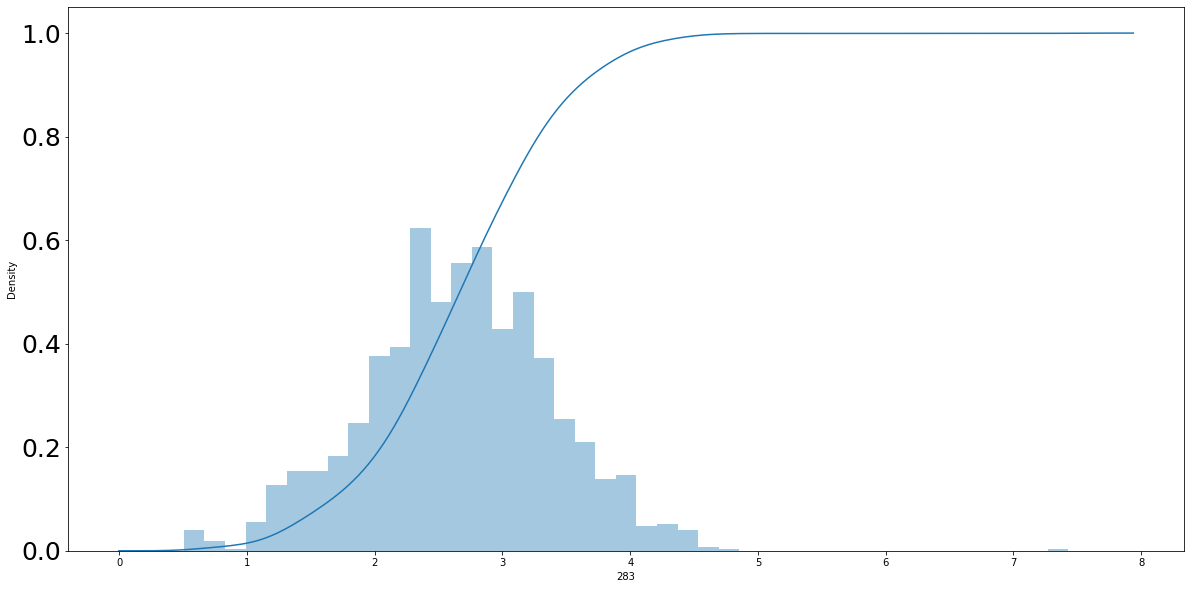

In [103]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.yticks(fontsize=25)
sns.distplot(test_data, kde_kws = {'cumulative': True})
#sns.displot(test_data, kind='ecdf') #if in the future the above doesn't work anymore

In [37]:
get_cdf(test_data,3) 
#This returns the probability of selected a value less than the specified limit given the distribution.

0.6789007228050281

In [38]:
help(norm.cdf)

Help on method cdf in module scipy.stats._distn_infrastructure:

cdf(x, *args, **kwds) method of scipy.stats._continuous_distns.norm_gen instance
    Cumulative distribution function of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    cdf : ndarray
        Cumulative distribution function evaluated at `x`



In [39]:
test_rules['prob_LT']=[get_cdf(clean_data(data[str(test_rules.loc[x,'Feature'])]),test_rules.loc[x,'limit']) for x in test_rules.index]

In [40]:
test_rules

Feature Rule         limit   prob_LT
0        64   LT  2.516000e+01  0.914795
1       283   LT  2.050000e+00  0.205550
2       280   LT  1.000000e-02  0.051713
3       307   LT  8.000000e-02  0.019321
4       561   LT  3.333000e+01  0.574035
5       472   LT  1.676600e+02  0.774556
6       454   LT  5.150000e+00  0.156521
7       457   LT  8.280000e+00  0.957398
8       339   LT  1.032000e+01  0.750510
9       304   LT  3.000000e-02  0.053689
10      494   LT  2.900000e-01  0.404359
11      494   LT  3.000000e-01  0.408244
12      437   LT  4.080000e+00  0.565007
13      434   LT  5.000000e+13  1.000000
14      489   LT  5.924700e+02  0.975196
15      102   LT -9.000000e-02  0.034882
16      493   LT  2.240000e+00  0.401263
17       38   LT  8.688000e+01  0.642694

# Adjusting a feature distribution

The above method is computationally expensive and difficult to apply in a real-world setting. What if we take a feature and just skew its distribution? Can we increase the factory yield? Take feature 59 for example.

In [349]:
print("feature 59 mean:", X_train['59'].mean())
print("feature 59 median:", X_train['59'].median())
print("feature 59 std:", X_train['59'].std())
X_train['59']

feature 59 mean: 2.878767430423392
feature 59 median: 0.9427
feature 59 std: 9.573121754054577


415      8.3018
879     -3.7536
413     -3.0900
58      15.9527
354     22.1027
         ...   
1130    -4.7991
1294     2.6991
860      2.3182
1459    -0.0864
1126    -0.0236
Name: 59, Length: 1253, dtype: float64

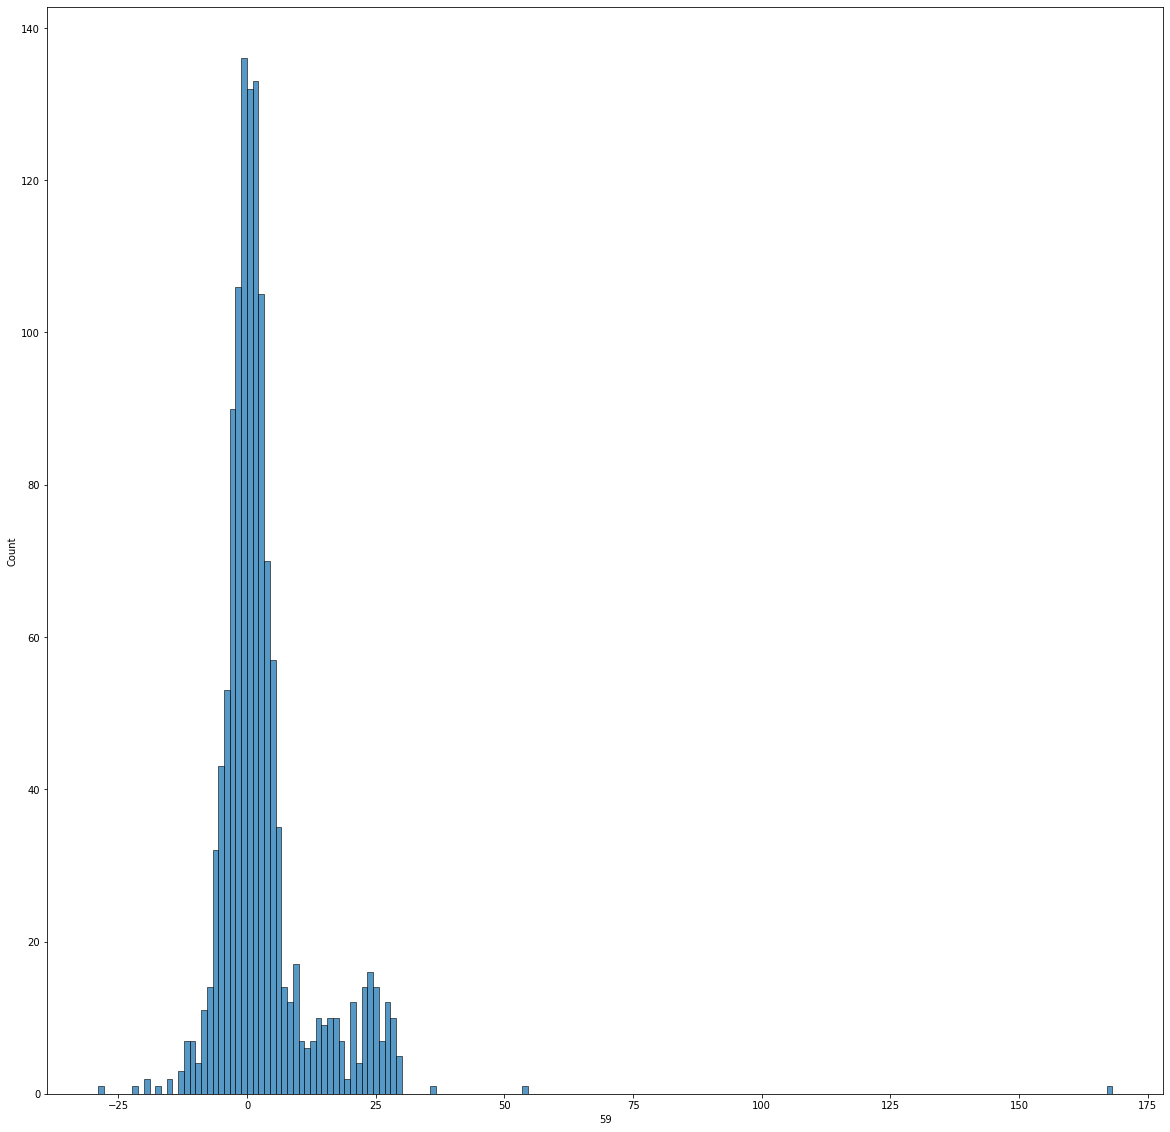

In [350]:
sns.histplot(X_train['59'])

In [351]:
#outliers are messing up the sigma. Filter it out and calc sigma again.

feature_59_filtered = X_train['59'].loc[X_train['59']<30]
print("feature 59 mean:",feature_59_filtered.mean())
sigma = feature_59_filtered.std()
print("feature 59 std:",feature_59_filtered.std())
print("0.25 sigma", 0.25*sigma)
print("0.50 sigma", 0.50*sigma)
print("0.75 sigma", 0.75*sigma)
print("1 sigma", 1*sigma)
print("1.25 sigma", 1.25*sigma)
print("1.50 sigma", 1.50*sigma)


feature 59 mean: 2.6791200722564104
feature 59 std: 8.184898293168757
0.25 sigma 2.0462245732921893
0.50 sigma 4.092449146584379
0.75 sigma 6.138673719876568
1 sigma 8.184898293168757
1.25 sigma 10.231122866460947
1.50 sigma 12.277347439753136


In [352]:
sigma_arr = {-2:-2*sigma,-1.5:-1.5*sigma,-1:-1*sigma, -0.75:-0.75*sigma,-0.5:-0.5*sigma,-0.25:-0.25*sigma,0:0, 0.25:0.25*sigma,0.5:0.5*sigma,0.75:0.75*sigma,1:1*sigma,1.5:1.5*sigma,2:2*sigma,3:3*sigma,4:4*sigma}
sigma_arr
# for key in sigma_arr:
#     print(sigma_arr[key])

{-2: -16.369796586337515,
 -1.5: -12.277347439753136,
 -1: -8.184898293168757,
 -0.75: -6.138673719876568,
 -0.5: -4.092449146584379,
 -0.25: -2.0462245732921893,
 0: 0,
 0.25: 2.0462245732921893,
 0.5: 4.092449146584379,
 0.75: 6.138673719876568,
 1: 8.184898293168757,
 1.5: 12.277347439753136,
 2: 16.369796586337515,
 3: 24.554694879506272,
 4: 32.73959317267503}

In [353]:
#Get yield of current training set

counts_arr = Counter(y_train)
fails=counts_arr[1]
total=len(y_train)
print("y_train counts:",counts_arr)
print("y_train yield:",fails/total)

y_train counts: Counter({-1: 1173, 1: 80})
y_train yield: 0.06384676775738228


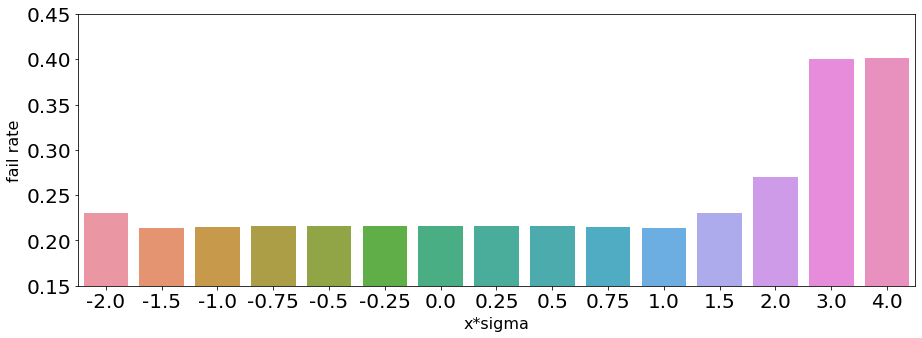

In [354]:
X_train_skew = X_train.copy()
fail_rate_list=[]
for key in sigma_arr:
#     print("key:",key)
#     print("delta:",sigma_arr[key])
    
    X_train_skew['59'] = X_train_skew['59'] + sigma_arr[key]
#     print("new mean:",X_train_skew['59'].mean())
    skew_predict = tree_model_opt.predict(X_train_skew)
    counts_arr = Counter(skew_predict)
#     print("counts",counts_arr)
    fails=counts_arr[1]
    total=len(y_train)
#     print("skew fail rate for",key,"sigma:",fails/total)
    fail_rate_list.append(fails/total)


plt.rcParams['figure.figsize'] = [15,5]
plt.ylabel('fail rate',fontsize=16)
plt.yticks(fontsize=20)
plt.xlabel('x*sigma', fontsize=16)
plt.xticks(fontsize=20)
plt.ylim(0.15,0.45)

sns.barplot(x=list(sigma_arr.keys()),y=fail_rate_list)

Not a lot of improvement by just skewing feature 59 up or down. The optimal mean value of feature 59 is already what it is. So can't make a blanket recommendation to just skew this feature. But can we make recommendations for each specific lot based on its history and assumptions about future operations?

In [355]:
#find a good row that has a fail prediction
X_train_predictions = tree_model_opt.predict(X_train)
X_train_predict = X_train.copy()
X_train_predict['predictions'] = X_train_predictions
X_train_predict.to_csv("X_train_predictions.csv")

#Row index 415 should fail


In [370]:
test_row=415
X_1row = X_train.loc[[test_row],:].copy()
single_pred = tree_model_opt.predict(X_1row)
print("actual row pred:",single_pred)
print("actual feature 59 value:",X_1row.loc[test_row,'59'])
print("feature 59 mean:", X_train['59'].mean())

#We are simulating parameter 59. 
#All params before 59 are defined, but we will assume params after 59 are going to be their average value.
future_means = X_train.mean()[47:] #feature 59 is index 46. Next feature is feature 61, which is index 47.

#replace all the parameters downstream of param 59 to their average values.
for idx in future_means.index:
    X_1row[str(idx)]=future_means[idx]

single_pred = tree_model_opt.predict(X_1row)
print("synthetic row pred:",single_pred)

X_1row_skew = X_1row.copy()

#param 59 mean is 2.9
for key in sigma_arr:
    new_val = X_1row['59'] + sigma_arr[key]
    #new_val = 2.4 + sigma_arr[key]
    X_1row_skew['59'] = new_val
    single_pred = tree_model_opt.predict(X_1row_skew)
    single_pred_proba = tree_model_opt.predict_proba(X_1row_skew)
    print("prediction for",key,"sigma with value",'{0:.2f}'.format(new_val.loc[test_row]),":",single_pred,"prob:",single_pred_proba)
    #print("prediction for",key,"sigma with value",new_val,":",single_pred,"prob:",single_pred_proba)








actual row pred: [1]
actual feature 59 value: 8.3018
feature 59 mean: 2.878767430423392
synthetic row pred: [1]
prediction for -2 sigma with value -8.07 : [-1] prob: [[0.553 0.447]]
prediction for -1.5 sigma with value -3.98 : [-1] prob: [[0.556 0.444]]
prediction for -1 sigma with value 0.12 : [-1] prob: [[0.55 0.45]]
prediction for -0.75 sigma with value 2.16 : [-1] prob: [[0.522 0.478]]
prediction for -0.5 sigma with value 4.21 : [-1] prob: [[0.502 0.498]]
prediction for -0.25 sigma with value 6.26 : [1] prob: [[0.474 0.526]]
prediction for 0 sigma with value 8.30 : [1] prob: [[0.465 0.535]]
prediction for 0.25 sigma with value 10.35 : [1] prob: [[0.456 0.544]]
prediction for 0.5 sigma with value 12.39 : [1] prob: [[0.451 0.549]]
prediction for 0.75 sigma with value 14.44 : [1] prob: [[0.449 0.551]]
prediction for 1 sigma with value 16.49 : [1] prob: [[0.449 0.551]]
prediction for 1.5 sigma with value 20.58 : [1] prob: [[0.447 0.553]]
prediction for 2 sigma with value 24.67 : [1] pr

# Unsupervised Learning

Try to find clusters and figured out what the pass/fail rates are of each.


In [33]:
data.head()

Time        0        1          2          3       4  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334   

          6       8       9      10  ...       570     571    572     573  \
0   97.6133  1.5005  0.0162 -0.0034  ...  533.8500  2.1113   8.95  0.3157   
1  102.3433  1.4966 -0.0005 -0.0148  ...  535.0164  2.4335   5.92  0.2653   
2   95.4878  1.4436  0.0041  0.0013  ...  535.0245  2.0293  11.21  0.1882   
3  104.2367  1.4882 -0.0124 -0.0033  ...  530.5682  2.0253   9.33  0.1738   
4  100.3967  1.5031 -0.0031 -0.0072  ...  532.0155  2.0275   8.83  0.2224   

      582     583     586     587       589  Pass/Fail  
0  0.5005  0.0118     NaN     NaN       NaN         -1  
1  0.5019  0.0223  0.0096  0.0201  208.2045         -1  
2  0.4958  0.0157  0.0584  0.0484   82.8602          1  
3  0.4990  0.0103  0.0202  0.0149   73.8432         -1  
4  0.4800  0.4766  0.0202  0.0149   73.8432         -1  

[5 rows x 212 columns]

In [34]:
#initial K-means clustering
kmeans = KMeans()
kmeans.set_params(n_clusters=8) #8 is the default
UL_data = data.drop(['Time','Pass/Fail'],axis=1).fillna(data.mean())
kmeans.fit(UL_data)

KMeans()

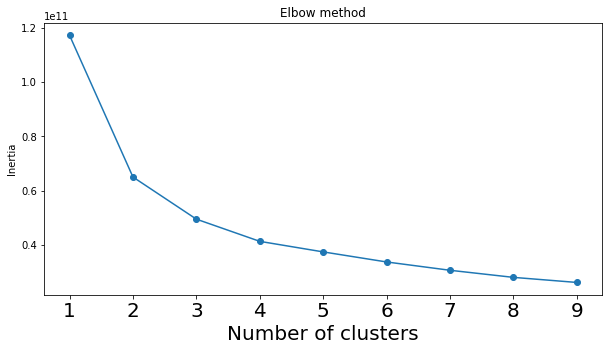

In [35]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.xlabel('N clusters',fontsize=20)
plt.xticks(fontsize=20)
plot_inertia(kmeans, UL_data, range(1, 10))
#Looks like elbow is between 2 and 3. Let's try 2 and see if they are the same clusters as pass/fail.

In [36]:
kmeans.set_params(n_clusters=2)
kmeans.fit(UL_data)

KMeans(n_clusters=2)

In [37]:
UL_data

0        1          2          3       4         6         8  \
0     3030.93  2564.00  2187.7333  1411.1265  1.3602   97.6133  1.500500   
1     3095.78  2465.14  2230.4222  1463.6606  0.8294  102.3433  1.496600   
2     2932.61  2559.94  2186.4111  1698.0172  1.5102   95.4878  1.443600   
3     2988.72  2479.90  2199.0333   909.7926  1.3204  104.2367  1.488200   
4     3032.24  2502.87  2233.3667  1326.5200  1.5334  100.3967  1.503100   
...       ...      ...        ...        ...     ...       ...       ...   
1562  2899.41  2464.36  2179.7333  3085.3781  1.4843   82.2467  1.342400   
1563  3052.31  2522.55  2198.5667  1124.6595  0.8763   98.4689  1.433300   
1564  2978.81  2379.78  2206.3000  1110.4967  0.8236   99.4122  1.462862   
1565  2894.92  2532.01  2177.0333  1183.7287  1.5726   98.7978  1.462200   
1566  2944.92  2450.76  2195.4444  2914.1792  1.5978   85.1011  1.462862   

             9        10        11  ...     559       570     571    572  \
0     0.016200 -0.003400  0.945500  ...  0.4385  533.8500  2.1113   8.95   
1    -0.000500 -0.014800  0.962700  ...  0.1745  535.0164  2.4335   5.92   
2     0.004100  0.001300  0.961500  ...  0.3718  535.0245  2.0293  11.21   
3    -0.012400 -0.003300  0.962900  ...  0.7288  530.5682  2.0253   9.33   
4    -0.003100 -0.007200  0.956900  ...  0.2156  532.0155  2.0275   8.83   
...        ...       ...       ...  ...     ...       ...     ...    ...   
1562 -0.004500 -0.005700  0.957900  ...  0.3553  536.3418  2.0153   7.98   
1563 -0.006100 -0.009300  0.961800  ...  0.3105  537.9264  2.1814   5.48   
1564 -0.000841  0.000146  0.964353  ...  0.1266  530.3709  2.3435   6.49   
1565 -0.007200  0.003200  0.969400  ...  0.1920  534.3936  1.9098   9.13   
1566 -0.000841  0.000146  0.964353  ...  0.2327  528.7918  2.0831   6.81   

         573     582     583       586       587         589  
0     0.3157  0.5005  0.0118  0.021458  0.016475   99.670066  
1     0.2653  0.5019  0.0223  0.009600  0.020100  208.204500  
2     0.1882  0.4958  0.0157  0.058400  0.048400   82.860200  
3     0.1738  0.4990  0.0103  0.020200  0.014900   73.843200  
4     0.2224  0.4800  0.4766  0.020200  0.014900   73.843200  
...      ...     ...     ...       ...       ...         ...  
1562  0.2363  0.4988  0.0143  0.006800  0.013800  203.172000  
1563  0.3891  0.4975  0.0131  0.006800  0.013800  203.172000  
1564  0.4154  0.4987  0.0153  0.019700  0.008600   43.523100  
1565  0.3669  0.5004  0.0178  0.026200  0.024500   93.494100  
1566  0.4774  0.4987  0.0181  0.011700  0.016200  137.784400  

[1567 rows x 210 columns]

In [38]:
len(data)

1567

In [39]:
#get the clusters
pd.Series(kmeans.labels_).unique()

array([0, 1])

In [40]:
len(kmeans.labels_)

1567

In [41]:
data['clusters'] = kmeans.labels_

In [42]:
data

Time        0        1          2          3       4  \
0     2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602   
1     2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294   
2     2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102   
3     2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204   
4     2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334   
...                   ...      ...      ...        ...        ...     ...   
1562  2008-10-16 15:13:00  2899.41  2464.36  2179.7333  3085.3781  1.4843   
1563  2008-10-16 20:49:00  3052.31  2522.55  2198.5667  1124.6595  0.8763   
1564  2008-10-17 05:26:00  2978.81  2379.78  2206.3000  1110.4967  0.8236   
1565  2008-10-17 06:01:00  2894.92  2532.01  2177.0333  1183.7287  1.5726   
1566  2008-10-17 06:07:00  2944.92  2450.76  2195.4444  2914.1792  1.5978   

             6       8       9      10  ...     571    572     573     582  \
0      97.6133  1.5005  0.0162 -0.0034  ...  2.1113   8.95  0.3157  0.5005   
1     102.3433  1.4966 -0.0005 -0.0148  ...  2.4335   5.92  0.2653  0.5019   
2      95.4878  1.4436  0.0041  0.0013  ...  2.0293  11.21  0.1882  0.4958   
3     104.2367  1.4882 -0.0124 -0.0033  ...  2.0253   9.33  0.1738  0.4990   
4     100.3967  1.5031 -0.0031 -0.0072  ...  2.0275   8.83  0.2224  0.4800   
...        ...     ...     ...     ...  ...     ...    ...     ...     ...   
1562   82.2467  1.3424 -0.0045 -0.0057  ...  2.0153   7.98  0.2363  0.4988   
1563   98.4689  1.4333 -0.0061 -0.0093  ...  2.1814   5.48  0.3891  0.4975   
1564   99.4122     NaN     NaN     NaN  ...  2.3435   6.49  0.4154  0.4987   
1565   98.7978  1.4622 -0.0072  0.0032  ...  1.9098   9.13  0.3669  0.5004   
1566   85.1011     NaN     NaN     NaN  ...  2.0831   6.81  0.4774  0.4987   

         583     586     587       589  Pass/Fail  clusters  
0     0.0118     NaN     NaN       NaN         -1         0  
1     0.0223  0.0096  0.0201  208.2045         -1         0  
2     0.0157  0.0584  0.0484   82.8602          1         0  
3     0.0103  0.0202  0.0149   73.8432         -1         0  
4     0.4766  0.0202  0.0149   73.8432         -1         0  
...      ...     ...     ...       ...        ...       ...  
1562  0.0143  0.0068  0.0138  203.1720         -1         0  
1563  0.0131  0.0068  0.0138  203.1720         -1         0  
1564  0.0153  0.0197  0.0086   43.5231         -1         0  
1565  0.0178  0.0262  0.0245   93.4941         -1         0  
1566  0.0181  0.0117  0.0162  137.7844         -1         0  

[1567 rows x 213 columns]

Pivot table of the pass/fail pareto in the 2 clusters. Use Time as the column to count. Any other feature would be ok.


In [43]:
data.groupby(['clusters','Pass/Fail'])['Time'].count()
#note -1 is pass, 1 is fail.

clusters  Pass/Fail
0         -1           1163
           1             82
1         -1            300
           1             22
Name: Time, dtype: int64

In [44]:
1463/(1463+104)

0.9336311423101468

Cluster 0 is 93.4% passing. Cluster 1 is 93.1% passing and is majority of the data. Very similar yield, but the products could be different!

In [85]:
data.groupby('Pass/Fail')['Time'].count()

Pass/Fail
-1    1463
 1     104
Name: Time, dtype: int64

The general yield is 93.36%

In [87]:
feature_cols = data.drop(['Time','Pass/Fail','clusters'], axis=1).columns
pval = []

for feature in feature_cols:
    print('feature ',feature)
    try:
        result = kruskal(data[data['clusters']==0][str(feature)],data[data['clusters']==1][str(feature)], nan_policy='omit')[1]
        pval.append(result)
    except ValueError as e:
        print(e)
        if(str(e) == 'All numbers are identical in kruskal'):
            print("appending 100")
            pval.append(100)
        else:
            print('appending nan')
            pval.append(np.nan)
        


feature  0
feature  1
feature  2
feature  3
feature  4
feature  6
feature  8
feature  9
feature  10
feature  11
feature  12
feature  14
feature  15
feature  16
feature  17
feature  18
feature  19
feature  20
feature  21
feature  22
feature  23
feature  24
feature  25
feature  28
feature  29
feature  31
feature  32
feature  33
feature  34
feature  35
feature  37
feature  38
feature  39
feature  40
feature  41
feature  43
feature  44
feature  45
feature  47
feature  48
feature  51
feature  53
feature  55
feature  56
feature  57
feature  58
feature  59
feature  61
feature  62
feature  63
feature  64
feature  67
feature  68
feature  71
feature  74
feature  75
feature  76
feature  77
feature  78
feature  79
feature  80
feature  81
feature  82
feature  83
feature  84
feature  86
feature  87
feature  88
feature  89
feature  90
feature  91
feature  92
feature  93
feature  94
feature  95
feature  99
feature  100
feature  102
feature  103
feature  107
feature  108
feature  113
feature  114
featu

In [88]:
pval

[0.018972820219559258,
 0.296064906811363,
 0.39675327801533933,
 0.15556704615449524,
 0.36158357568582267,
 0.01365096567453429,
 0.41160770693068593,
 0.3016781338402005,
 0.7994086300614273,
 0.5887814938591224,
 0.2830391174128766,
 0.07837624528113257,
 0.9535692768520206,
 0.8616610513442958,
 0.24488500505509858,
 0.26089478105822317,
 0.00044908396086878804,
 1.691641844220151e-05,
 1.3565274798576257e-10,
 4.2014118530906773e-10,
 0.861705493682986,
 9.076263474177879e-05,
 3.6672456141484983e-28,
 4.366144457794281e-10,
 9.560111138431451e-46,
 1.545920720355481e-18,
 0.13831595498160115,
 0.0004639794897264748,
 0.2458247060494244,
 0.010113666889708186,
 0.24213091091746664,
 0.4250637303901854,
 0.6031906262644375,
 0.027145480683441702,
 0.2984629218743138,
 0.16928322790055622,
 0.07052397906385138,
 0.2993166231676154,
 0.5825863774817353,
 0.8017959845207937,
 0.9394919033933062,
 0.9379208970125549,
 0.18536268467907288,
 0.3720572865188221,
 0.1234932190116065,
 0.0

In [89]:
#make a DF wit the features and their p-values
feature_pvals =pd.DataFrame({'features':feature_cols,'pvals':pval})

In [90]:
#Sort by p values
feature_pvals.sort_values(by='pvals', inplace=True)

In [91]:
mismatch_features = feature_pvals[feature_pvals['pvals']<0.05]
mismatch_features

features          pvals
116      162  1.288712e-168
24        29   9.560111e-46
176      438   1.803845e-36
177      439   1.614301e-30
22        25   3.667246e-28
121      169   1.352627e-19
25        31   1.545921e-18
119      167   3.000493e-17
120      168   1.386128e-11
18        21   1.356527e-10
19        22   4.201412e-10
23        28   4.366144e-10
58        78   2.188451e-06
175      433   8.701241e-06
17        20   1.691642e-05
21        24   9.076263e-05
143      212   2.140573e-04
96       132   2.320366e-04
59        79   2.607017e-04
165      255   4.197564e-04
16        19   4.490840e-04
27        33   4.639795e-04
196      542   4.676759e-04
197      543   8.924437e-04
78       103   1.000751e-03
144      213   1.003487e-03
103      139   1.120310e-03
179      468   1.859072e-03
46        59   3.174399e-03
113      159   3.359715e-03
193      510   3.834725e-03
185      484   7.371570e-03
29        35   1.011367e-02
83       115   1.214603e-02
5          6   1.365097e-02
91       125   1.780673e-02
166      267   1.819608e-02
0          0   1.897282e-02
86       118   2.089081e-02
108      146   2.166816e-02
115      161   2.234611e-02
57        77   2.536016e-02
45        58   2.546086e-02
125      173   2.587716e-02
94       129   2.672456e-02
33        40   2.714548e-02
126      175   3.068022e-02
128      177   3.372573e-02
146      215   4.070300e-02
141      210   4.149183e-02
202      571   4.655644e-02

(array([0, 1]), <a list of 2 Text xticklabel objects>)

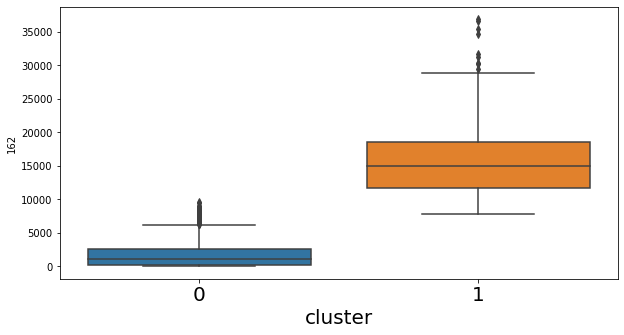

In [92]:
sns.boxplot(data=data,x='clusters',y='162')
plt.xlabel('cluster',fontsize=20)
plt.xticks(fontsize=20)

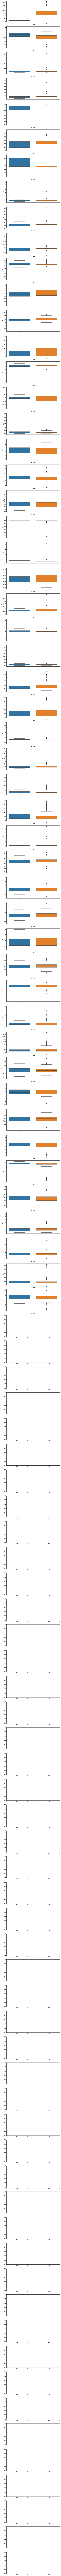

In [93]:
#boxplot all the top mismatches
plt.rcParams['figure.figsize'] = [10,500]
fig,axes = plt.subplots(100,1)
i=0
for feature in mismatch_features["features"]:
    sns.boxplot(data=data,x='clusters',y=str(feature),ax = axes[i])
    i+=1
    

In [ ]:
#Try to compare top mismatch feature 162 with other features and color by cluster. Look for anything interesting.

feature_list = data.columns.drop(['Time','Pass/Fail','clusters'])
n = len(feature_list)
plt.rcParams['figure.figsize'] = [5,700]
fig,axes = plt.subplots(538,1)
i=0
for feature in feature_list:
    sns.scatterplot(data=data,x='162',y=str(feature), hue='clusters',ax = axes[i])
    i+=1
    
    
